In [1]:
# Authors: 
# - Luigi Frigione < luigi.frigione@studenti.unipd.it >
# - Marco Stefani < marco.stefani.3@studenti.unipd.it > 
# - Edoardo Parpaiola < edoardo.parpaiola@studenti.unipd.it >

import os
import time
import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from typing import Self
from scipy import stats
from scipy.stats import norm
from scipy.integrate import quad
from math import ceil, sqrt, prod

# Direct Random Weighted Graphs


### Random Weight
This class is responsible to manage the edge behaviour

In [10]:
class RandomWeight:

    # IP rw1 first random weight
    # IP rw2 second random weight
    # OR the probability that rw1 <= rw2 assuming independence
    @staticmethod
    def prob_less(rw1 : Self, rw2 : Self) -> float:
        return norm.cdf(0, loc = rw1.mean - rw2.mean, scale = sqrt(rw1.variance + rw2.variance))
    
    # IP a first coefficient
    # IP x1 first random weight
    # IP b second coefficient
    # IP x2 second random weight
    # OR a * x1 + b * x2
    @staticmethod
    def linear_combination(a : float, x1 : Self, b : float, x2 : Self) -> Self:
        return RandomWeight(a * x1.mean + b * x2.mean, sqrt(a**2 * x1.variance + b**2 * x2.variance))

    def __init__(self : Self, mean : float, standard_deviation : float) -> Self:
        self.mean : float = mean
        self.standard_deviation : float = standard_deviation
        self.variance : float = standard_deviation**2

    def __str__(self : Self) -> str:
        return f"N({round(self.mean, 2)}, {round(self.variance, 2)})"

    def sample(self : Self) -> float:
        return np.random.normal(loc = self.mean, scale = self.standard_deviation)
    
    def cdf(self : Self, x : float) -> float:
        return norm.cdf(x, loc = self.mean, scale = self.standard_deviation)

    def pdf(self : Self, x : float) -> float:
        return norm.pdf(x, loc = self.mean, scale = self.standard_deviation)
    
    # IP rw random weight
    # OR the probability that self <= rw assuming independence
    def prob_less_than(self : Self, rw : Self) -> float:
        return Self.prob_less(self, rw)

### DRWG
This class will represent our model

In [21]:
class DRWG:
    
    @staticmethod
    def generate_random(n : int, p : float, seed : int, mean_interval : tuple[float, float], std_interval : tuple[float, float]) -> nx.DiGraph:
        graph : nx.DiGraph = nx.fast_gnp_random_graph(n, p, seed, directed = True)
        
        for u, v in graph.edges():
            random_mean : float = np.random.uniform(mean_interval[0], mean_interval[1])
            random_std : float = np.random.uniform(std_interval[0], std_interval[1])
            
            rw : RandomWeight = RandomWeight(random_mean, random_std)
            
            graph[u][v]['label'] = rw.__str__()
            graph[u][v]['random_weight'] = rw

        return graph
    
    @staticmethod
    def from_file(file_path: str) -> nx.DiGraph:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File '{file_path}' does not exist.")
        
        graph : nx.DiGraph = nx.DiGraph()

        graph_data = nx.read_graphml(file_path)
        
        n : int = 0
        node_names = {}

        for curr_u, curr_v, data in graph_data.edges(data = True):
            if not node_names.__contains__(curr_u):
                graph.add_node(n, label = curr_u)
                node_names[curr_u] = n
                n = n + 1
            
            if not node_names.__contains__(curr_v):
                graph.add_node(n, label = curr_v)
                node_names[curr_v] = n
                n = n + 1
            
            weight = data.get('weight', None)

            if weight is not None:
                mean, stddev = map(float, weight.split('_'))
                rw : RandomWeight = RandomWeight(mean, stddev)
                graph.add_edge(node_names[curr_u], node_names[curr_v], label = rw.__str__(), random_weight = rw)
            else:
                raise ValueError("The edge weight field cannot be None!")
        
        return graph
    
    # Default values
    _N : int = 10
    _P : float = .3
    _MEAN_INTERVAL : tuple[float, float] = (1, 100)
    _STD_INTERVAL : tuple[float, float] = (sqrt(0.1), sqrt(0.4))
    _SEED : int = 2060685 + 2139662 + 2139221
    _TITLE : str = "Graph"
    _FIGSIZE : tuple[float, float] = (10, 10)
    _WITH_LABELS : bool = True
    _EDGE_LABELS : bool = True
    _NODE_COLOR : str = "lightblue"
    _EDGE_COLOR : str = "gray"
    _NODE_SIZE : int = 500
    _FONT_SIZE : int = 10
    _ARROWSIZE : int = 20
    _FONT_COLOR : str = "red"
    _SHORTEST_PATH_NODE_COLOR : str = "orange"
    _SHORTEST_PATH_EDGE_COLOR : str = "red" 

    
    def __init__(self : Self, n : int = _N, p : float = _P, seed : int = _SEED, file_path = None) -> Self:
        self.graph : nx.DiGraph = self.generate_random(n, p, seed, self._MEAN_INTERVAL, self._STD_INTERVAL) if file_path is None else self.from_file(file_path)

        self.n : int = self.graph.number_of_nodes()
        self.m : int = self.graph.number_of_edges()
        
        # Initializing the path weight estimates (from one node to another) to None for all the node pairs
        self._distance_estimate = np.full((self.n, self.n), None, dtype = RandomWeight)
        
        # Initializing the path weight estimates for all the edges of the graph
        for u, v in self.graph.edges():
            self._distance_estimate[u][v] = self.get_random_weight(u, v)

        # Nodes position layout
        self.layout : nx.Mapping = nx.random_layout(self.graph, seed = self._SEED)

    def plot_graph(self : Self, graph : nx.DiGraph, title : str = _TITLE, figsize : tuple[int, int] = _FIGSIZE, with_labels : bool = _WITH_LABELS, node_color : str = _NODE_COLOR, edge_color : str = _EDGE_COLOR, node_size : int = _NODE_SIZE, font_size : int = _FONT_SIZE, font_color : str = _FONT_COLOR, arrowsize : int = _ARROWSIZE, show_edge_labels : bool = _EDGE_LABELS) -> None:
        # Draws the graph
        plt.figure(figsize = figsize)
        
        # Draws nodes and arcs
        nx.draw(graph, self.layout, with_labels = with_labels, node_color = node_color, edge_color = edge_color, node_size = node_size, font_size = font_size, arrowsize = arrowsize)

        # Draws arcs' labels
        if show_edge_labels:
            nx.draw_networkx_edge_labels(graph, self.layout, edge_labels = nx.get_edge_attributes(graph, 'label'), font_color = font_color, font_size = font_size)

        plt.title(title)
        plt.show()
    
    def plot(self : Self, title : str = _TITLE, figsize : int = _FIGSIZE, seed : int = _SEED, with_labels : bool = _WITH_LABELS, node_color : str = _NODE_COLOR, edge_color : str = _EDGE_COLOR, node_size : int = _NODE_SIZE, font_size : int = _FONT_SIZE, font_color : str = _FONT_COLOR, arrowsize : int = _ARROWSIZE) -> None:
        self.plot_graph(self.graph, title = title, figsize = figsize, with_labels = with_labels, node_color = node_color, edge_color = edge_color, node_size = node_size, font_size = font_size, font_color = font_color, arrowsize = arrowsize)

    def sample(self : Self) -> nx.DiGraph:
        sample_graph : nx.DiGraph = nx.DiGraph()
        
        for u, v in self.graph.edges():
            sample : float = self.graph.get_edge_data(u, v)["random_weight"].sample()
            sample_graph.add_edge(u, v, label = round(sample, 2), random_weight = sample)

        return sample_graph

    def weighted_in_degree(self : Self, node : int) -> RandomWeight:
        total_in_degree : RandomWeight = RandomWeight(0,0)

        for u, _ in self.graph.in_edges(node):
            edge_weight : RandomWeight = self.get_random_weight(u, node)
            total_in_degree : RandomWeight = RandomWeight.linear_combination(1, total_in_degree, 1, edge_weight)

        return total_in_degree
        
    def weighted_out_degree(self: Self, node : int) -> RandomWeight:
        total_out_degree = RandomWeight(0,0)

        for _, v in self.graph.out_edges(node):
            edge_weight : RandomWeight = self.get_random_weight(node, v)
            total_out_degree : RandomWeight = RandomWeight.linear_combination(1, total_out_degree, 1, edge_weight)

        return total_out_degree
    
    def in_degree(self : Self, node : int) -> int:
        return self.graph.in_degree(node)
    
    def out_degree(self : Self, node : int) -> int:
        return self.graph.in_degree(node)

    def in_edges(self : Self, node : int):
        return self.graph.in_edges(node)
    
    # IP s the source node
    # IP t the target node
    # OR True if there exist an oriented arc between s and t, False otherwise
    def has_edge(self : Self, s : int, t : int) -> bool:
        return self.graph.has_edge(s, t)
    
    def get_edge_data(self : Self, u : int, v : int):
        return self.graph.get_edge_data(u, v)

    def get_random_weight(self : Self, u : int, v : int) -> RandomWeight:
        return self.get_edge_data(u, v)["random_weight"]

    def has_path(self : Self, s : int, t : int) -> bool:
        return nx.has_path(self.graph, s, t)
    
    def set_min_estimate(self : Self, i : int, k : int, j : int) -> None:
        # Already initialized
        if i == j:
            return
        # d_ik + d_kj is +inf

        if self._distance_estimate[i][k]._estimate is None or self._distance_estimate[k][j]._estimate is None:
            return
        
        # here d_ik and d_kj are both not None
        d_new : RandomWeight = RandomWeight.linear_combination(1, self._distance_estimate[i][k]._estimate, 1, self._distance_estimate[k][j]._estimate)

        if(self._distance_estimate[i][j]._estimate is None):
            self._distance_estimate[i][j] = d_new
            return
        
        # here d_ik, d_kj and d_ij are all not None
        p_new : float = RandomWeight.linear_combination(1, d_new, -1, self._distance_estimate[i][j]._estimate).cdf(0)
        
        if p_new > 0.5:
            self._distance_estimate[i][j] = d_new
    
    def floyd_warshall(self : Self) -> None:
        for k in range(self.n):
            for i in range(self.n):
                for j in range(self.n):
                    self.set_min_estimate(i, k, j)

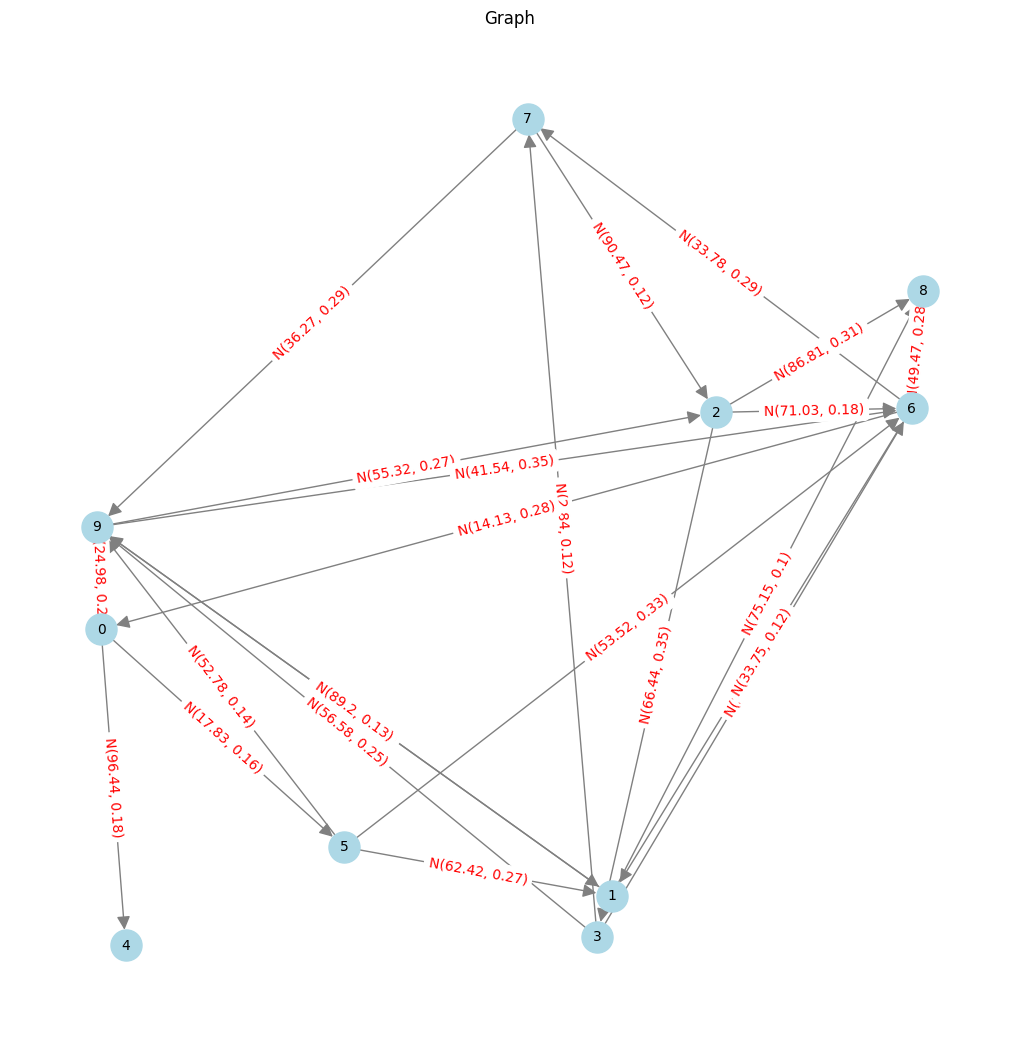

In [23]:
# Create an istance of the class
g1 = DRWG()

# Plot the model
g1.plot()

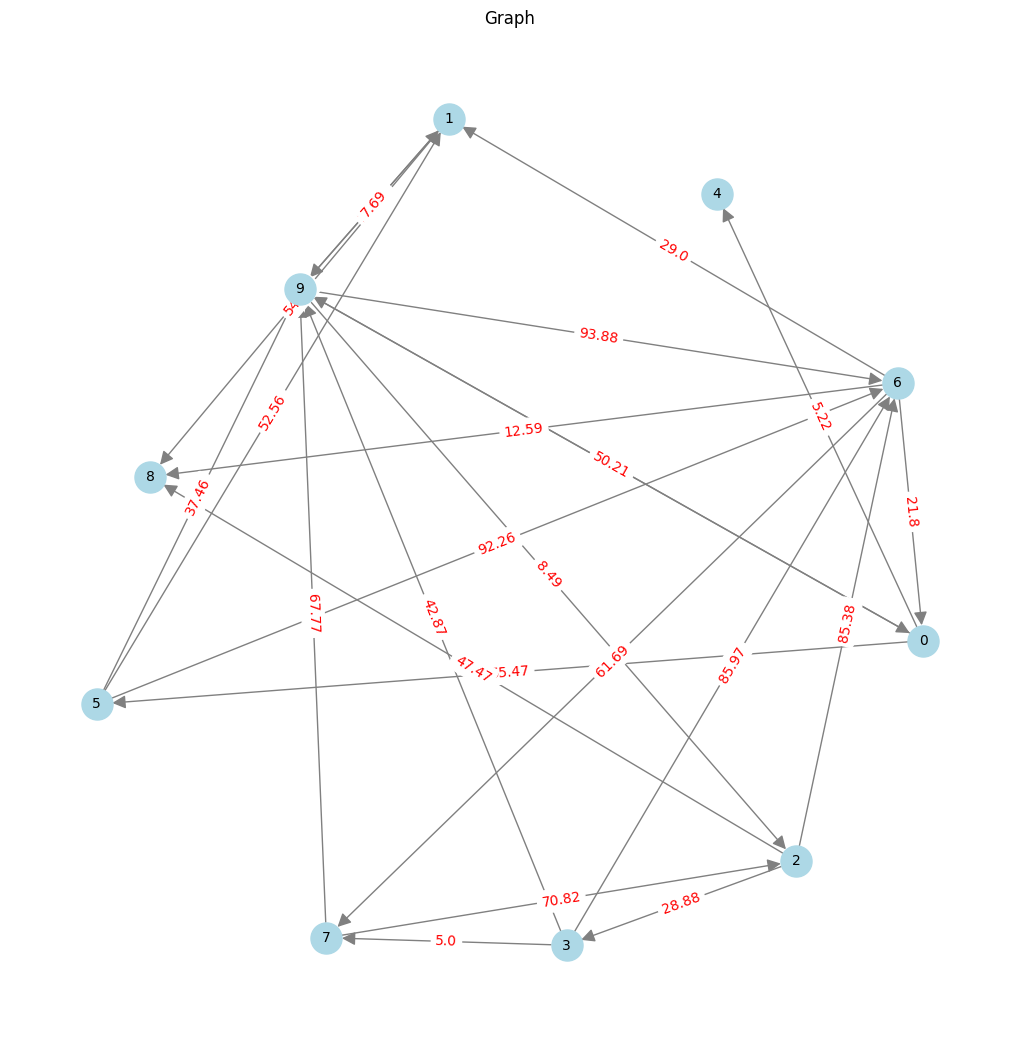

In [21]:
# Sample from the model
sample = g1.sample()

# Plot the sample
g1.plot_graph(sample)

## Max Formulation

### Exact distribution

In [18]:
class MAX:
    def __init__(self, rws : list[RandomWeight]):
        self.random_weights = rws

    def cdf(self, x):
        return prod(rw.cdf(x) for rw in self.random_weights)

    def pdf(self, x):
        return self.cdf(x) * sum((rw.pdf(x) / (rw.cdf(x) + 1e-17))  for rw in self.random_weights)

    def get_expectation(self, lb = -np.inf, ub = np.inf):
        return quad(lambda x: x * self.pdf(x), a = lb, b = ub)
    

class BoostMAX(MAX):
    def __init__(self, rws : list[RandomWeight], threshold_for_single_cdf : float = 0.003, upper_bound_precision: float = 5.0, same_distribution = False):
        super().__init__(rws)
        self.same_distribution = same_distribution
        self.lower_bound = self.calculate_lower_bound(threshold_for_single_cdf)
        self.upper_bound = self.calculate_upper_bound(upper_bound_precision)
    
    def calculate_lower_bound(self, threshold_for_single_cdf): 
        if self.same_distribution:
            return max(stats.norm.ppf(math.exp(math.log(threshold_for_single_cdf)/len(self.random_weights)), loc=v.mean, scale=v.standard_deviation) for v in self.random_weights)
        else:       
            return max(stats.norm.ppf(threshold_for_single_cdf, loc=rw.mean, scale=rw.standard_deviation) for rw in self.random_weights)
    
    def calculate_upper_bound(self, upper_bound_precision):
        return max(rw.mean + upper_bound_precision * rw.standard_deviation for rw in self.random_weights)
    
    def get_expectation(self):
        return super().get_expectation(lb=self.lower_bound, ub=self.upper_bound)

### Comparison

In [ ]:
start = 2
max_variables = 100
step = 1

exact_results = []
exact_computing_time = []

approximation_results = []
approximation_computing_time = []

n_variables = range(start, max_variables, step)

for n_variable in n_variables:
    print("N-Variables: ", n_variable)
    
    random_vars = [RandomWeight(np.random.uniform(1,4), np.random.uniform(0.1,0.4)) for i in range(n_variable)]
    
    start_time = time.time()
    mx = BoostMAX(random_vars)
    result, error = mx.get_expectation()
    approximation_results.append(result)
    approximation_computing_time.append(time.time() - start_time)
    
    start_time = time.time()
    mx = MAX(random_vars)
    result, error = mx.get_expectation()
    exact_results.append(result)
    exact_computing_time.append(time.time() - start_time)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# exact_results e approximation_results
axes[0].plot(n_variables, np.log(abs(np.array(exact_results) - np.array(approximation_results))), marker='o')
# axes[0].plot(n_variables, approximation_results, label='Approximation Results', color='orange', marker='s')
axes[0].set_title('Results Comparison')
axes[0].set_xlabel('Number of Variables')
axes[0].set_ylabel('log Error')
axes[0].legend()
axes[0].grid(True)

# exact_computing_time e approximation_computing_time
axes[1].plot(n_variables, exact_computing_time, label='Exact Computing Time', color = 'orange', marker='o')
axes[1].plot(n_variables, approximation_computing_time, label='Approximation Computing Time', color = 'green', marker='s')
axes[1].set_title('Computing Time Comparison')
axes[1].set_xlabel('Number of Variables')
axes[1].set_ylabel('Computing Time (s)')
axes[1].legend()
axes[1].grid(True)
# print
plt.tight_layout()
plt.show()

## Distance estimation
In this section an algorithm to estimate distances among nodes will be developed. This estimation can be interpreted as a static analisis of the graph. It can be than exploited to perform a dinamic algorithm when an instance is available.

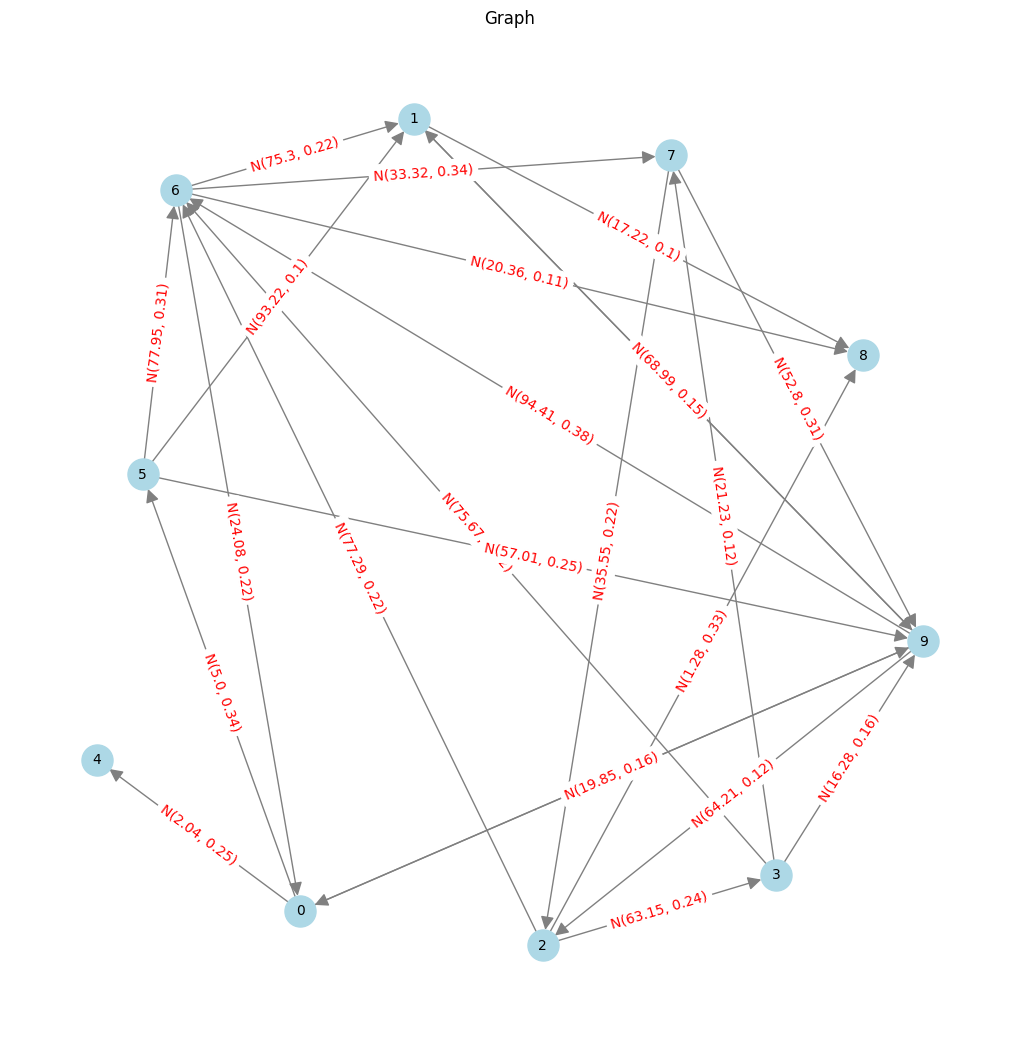

In [20]:
# Create an istance of the class
G = DRWG()

# Plot the model
G.plot()

In [21]:
G = DRWG(n=15)
G.floyd_warshall()

cell_width = 16

print("Vertices".ljust(cell_width), end = "")
for v in range(G.n):
    print(f"{v}".ljust(cell_width), end = "")
print()

for s in range(G.n):
    print(f"{s}".ljust(cell_width), end = "")
    for v in range(G.n):
        value = G._distance_estimate[s][v]._estimate
        print(f"{value}".ljust(cell_width), end = "")
    print()
print()


Vertices        0               1               2               3               4               5               6               7               8               9               10              11              12              13              14              
0               None            N(67.3, 0.43)   N(57.37, 0.51)  N(102.47, 0.77) N(56.19, 0.37)  N(44.19, 0.16)  N(111.75, 0.36) N(87.93, 0.79)  N(72.67, 0.55)  N(55.49, 0.16)  N(87.13, 0.58)  N(88.96, 0.52)  N(28.72, 0.3)   N(85.9, 0.41)   N(121.48, 0.3)  
1               N(47.89, 0.77)  None            N(68.17, 1.07)  N(35.17, 0.33)  N(21.48, 0.62)  N(46.57, 0.45)  N(74.19, 0.82)  N(38.17, 0.71)  N(5.37, 0.12)   N(6.68, 0.26)   N(52.41, 0.83)  N(39.19, 0.44)  N(39.52, 0.86)  N(36.14, 0.33)  N(57.61, 0.24)  
2               N(95.78, 0.33)  N(86.37, 0.11)  None            N(78.9, 0.18)   N(107.85, 0.73) N(105.74, 0.44) N(56.81, 0.28)  N(81.17, 0.67)  N(91.74, 0.23)  N(93.05, 0.37)  N(138.78, 0.94) N(82.21, 0.57)  N(82.52, 0.81)  N(122

In [22]:
G = DRWG(15)
#G.plot()

In [ ]:
tup = ()
length = 0

for u in range(G.n):
    for v in range(G.n):
        temp = nx.shortest_path_length(sample, u, v, weight="random_weight")
        if(temp > length):
            length = temp
            tup = (u, v)

print(tup)
print(length)

In [ ]:
# GREEDY 
s = 11
t = 10

if(s==t):
    print("Source==Terminal")
    exit(0)

if G._distance_estimate[s][t]._estimate == None:
    print("No path available")
    exit(-404)

current_node = s
path = [current_node]

visited = [False] * G.n

while(current_node != t):
    neighbours = [n for n in sample.successors(current_node)]
    if not neighbours:
        print("No path available")
        break
    
    neighbour_to_esaminate = []
    for neighbour in neighbours:
        estimate = G._distance_estimate[neighbour][t]._estimate
        print(visited[neighbour])
        print(estimate is not None)
        if visited[neighbour] == False and (neighbour == t or estimate is not None):
            print(current_node, neighbour, sample.get_edge_data(u = current_node, v = neighbour))
            print(estimate)
            if(neighbour == t):
                neighbour_to_esaminate.append((neighbour, sample.get_edge_data(u = current_node, v = neighbour)["random_weight"]))
            else:
                neighbour_to_esaminate.append((neighbour, sample.get_edge_data(u = current_node, v = neighbour)["random_weight"] + estimate.mean))
            
    if not neighbour_to_esaminate:
        print("No path available")
        break
    
    index = np.argmin([neighbour[1] for neighbour in neighbour_to_esaminate])
    
    current_node = neighbour_to_esaminate[index][0]
    visited[current_node] = True
    path.append(current_node)

cost = 0
print(path)

current_node = s
for next in path:
    if(next != s):
        cost += sample.get_edge_data(u = current_node, v = next)["random_weight"]
        current_node = next

print("cost: ", cost)

path = nx.shortest_path(sample, s, t, weight="random_weight")
print(path)

cost = 0
current_node = s
for next in path:
    if(next != s):
        cost += sample.get_edge_data(u = current_node, v = next)["random_weight"]
        current_node = next

print("cost: ", cost)


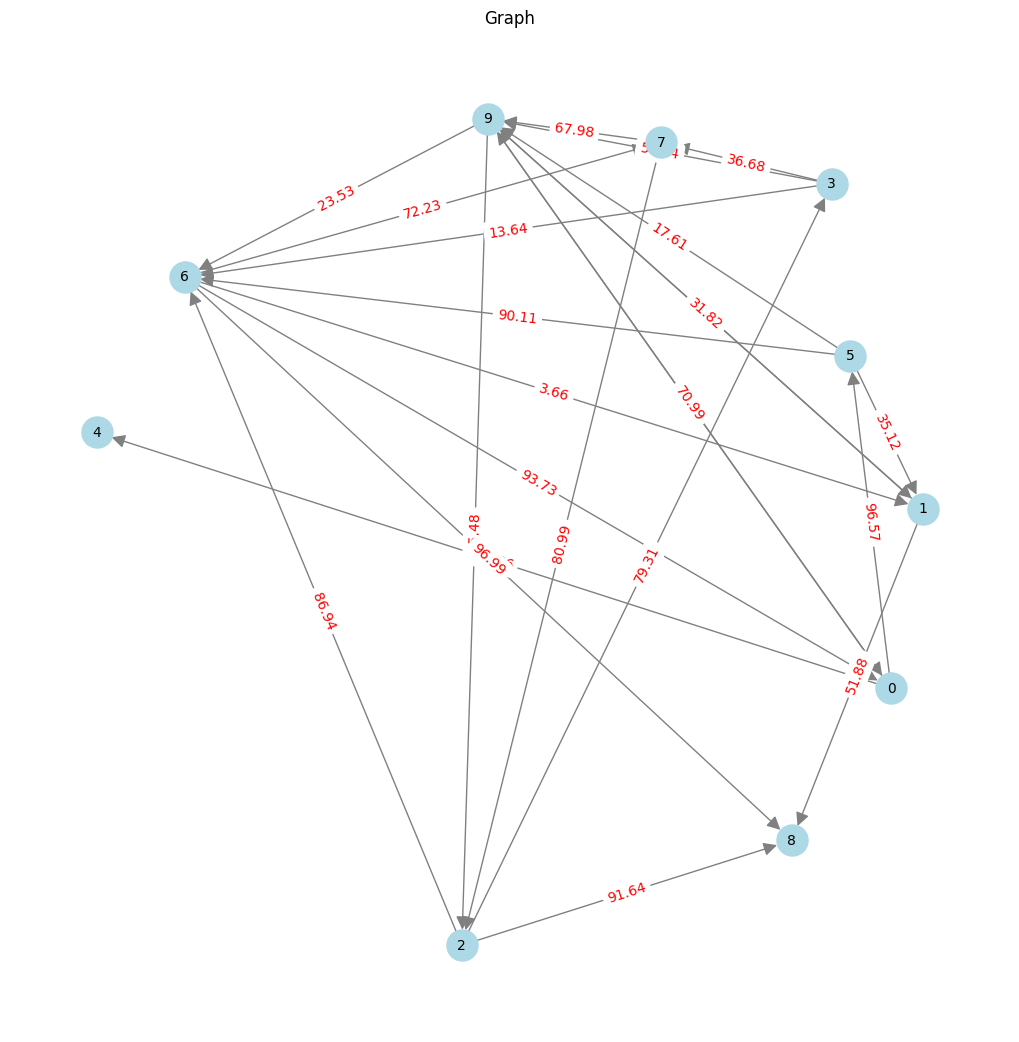

In [26]:
G.plot_graph(sample)

In [ ]:

def plot_with_shortest_path(self, shortest_path):

        node_colors = [self._SHORTEST_PATH_NODE_COLOR if node in shortest_path else self._NODE_COLOR for node in self.graph.nodes()]
        edge_colors = [self._SHORTEST_PATH_EDGE_COLOR if (u in shortest_path and v in shortest_path and (u, v) in zip(shortest_path[:-1], shortest_path[1:])) else self._EDGE_COLOR
                       for u, v in self.graph.edges()]

        self.plot_graph(sample, node_color = node_colors, edge_color = edge_colors)

plot_with_shortest_path(G, path)

In [29]:
#print(G.estimate_distances())
print(G.in_edges(0))

for i in range(G.n):
    for j in range(G.n):
        if not G.has_path(i, j):
            print("Non esiste un cammino da ", i," a ", j, ".")

if nx.is_strongly_connected(G.graph):
    print("connesso")
else:
    print("non connesso")

[(1, 0), (2, 0), (4, 0), (11, 0)]
connesso


(0.0, 0.0)
(18.980901431069565, 4.361614769983653e-10)


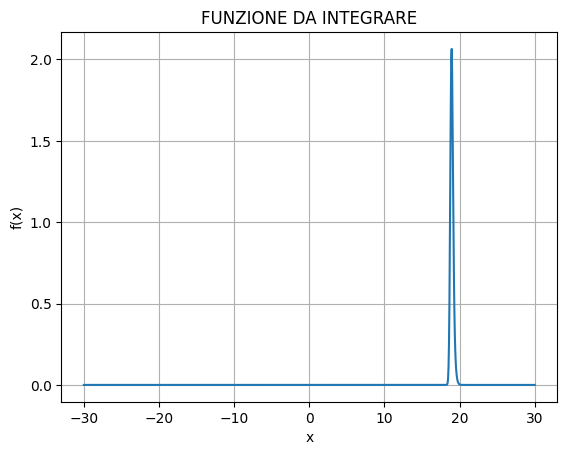

In [30]:
import matplotlib.pyplot as plt


random_vars = [RandomWeight(np.random.uniform(10,20), np.random.uniform(0.1,0.4)) for i in range(20)]
maa = MAX(random_vars)
maax = BoostMAX(random_vars, 0.003, 5)

# Plot the function over the finite range
x_vals = np.linspace(-30, 30, 1000)
y_vals = [ maa.pdf(x) for x in x_vals]

print(maa.get_expectation())
print(maax.get_expectation())

plt.plot(x_vals, y_vals)
plt.title("FUNZIONE DA INTEGRARE")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid()
plt.show()

In [ ]:
in_degrees = []
 
for v in g1.graph.nodes():
    in_edges = g1.graph.in_edges(v, data=True)
    mean = sum(edge[2]['random_weight'].mean for edge in in_edges) 
    std_dev = sqrt(sum(edge[2]['random_weight'].standard_deviation**2 for edge in in_edges))
    rw = RandomWeight(mean=mean, standard_deviation=std_dev)
    in_degrees.append(rw)
    
get_expectation_gumbel(in_degrees)

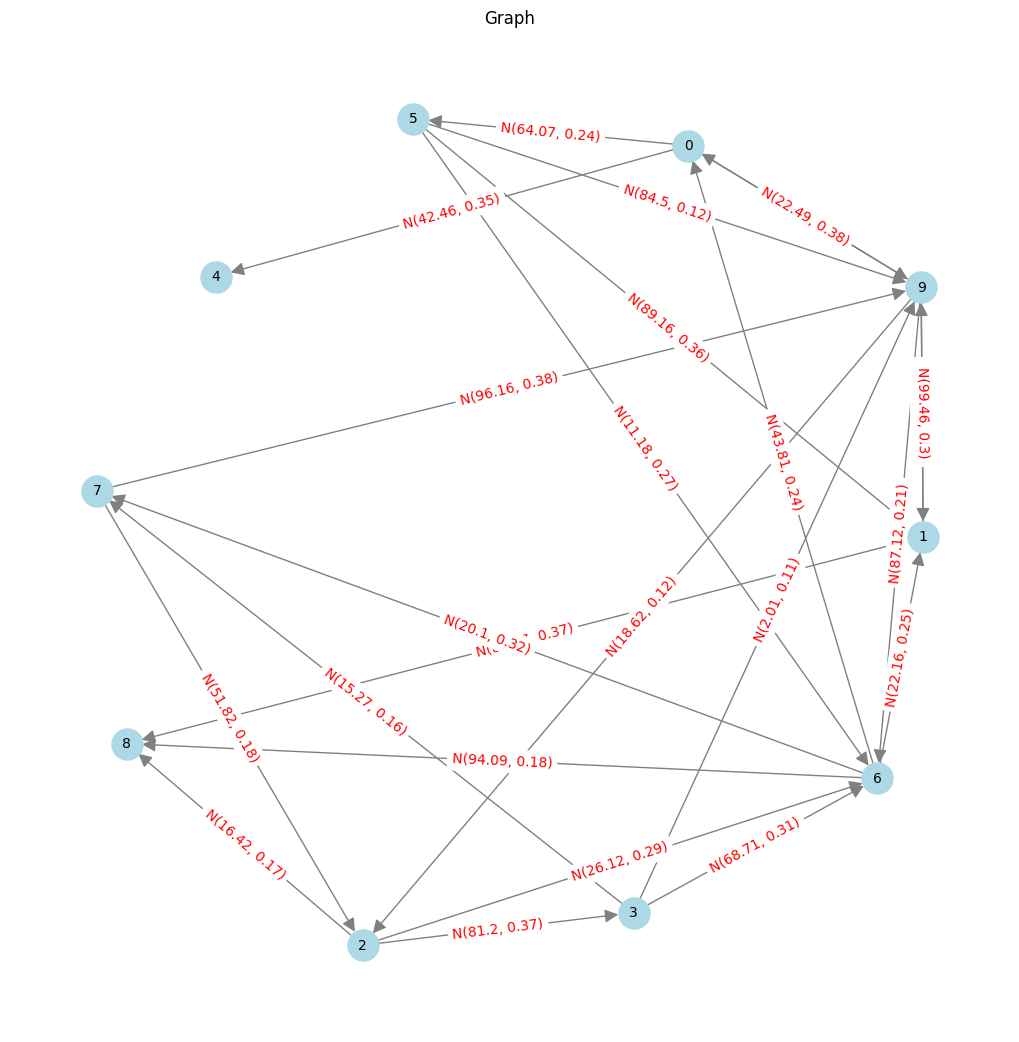

In [32]:
g1 = DRWG()
g1.plot()

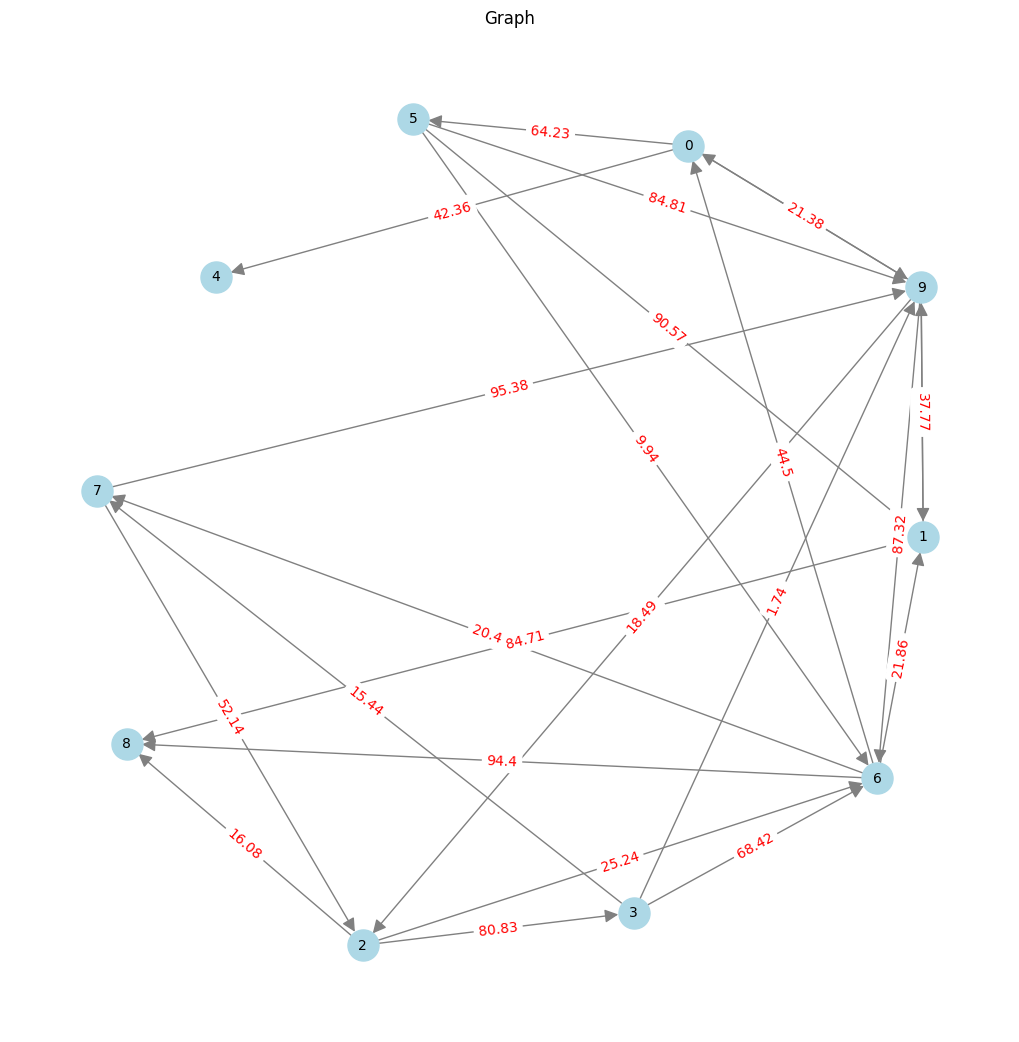

In [33]:
g1.plot_graph(g1.sample())

Uploading and generating the graph with real data downloaded from Binance.


In [ ]:
# Reading the graph from the XML file
crypto_graph = DRWG()
file_path = "data/01_01_2024.graphml"
crypto_graph.generate_graph_from_file(file_path)
crypto_graph.plot_graph(crypto_graph.graph, figsize=(40, 40), node_size=50, show_edge_labels = False)

print(f"Number of vertices: {crypto_graph.graph.number_of_nodes()}")
print(f"Number of arcs: {crypto_graph.graph.number_of_edges()}")

In [ ]:
# Sample from the model
sample = crypto_graph.sample()

# Plot the sample
crypto_graph.plot_graph(sample, figsize=(40, 40), node_size=50)